In [22]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [2]:
path = os.path.abspath('.\\kaggle_givemesomecredit_train.csv')

List of all the variables in the training dataset:

Dependent variable:
- output

Independent (10) variables:
- age
- credit_balance
- 1monplus_dlqin_freq (30-59 days)
- 2monplus_dlqin_freq (60-89 days)
- 3monplus_dlqin_freq (90 days or more)
- debt_ratio
- income
- num_credit_lines
- num_realestate_loans
- num_dependents

In [8]:
df = pd.read_csv(path)
df = df.dropna(axis=0)

In [9]:
df

,id,output,age,credit_balance,1monplus_dlqin_freq,2monplus_dlqin_freq,3monplus_dlqin_freq,debt_ratio,income,num_credit_lines,num_realestate_loans,dependents
0,1,1,45,0.766127,2,0,0,0.802982,9120.0,13,6,2.0
1,2,0,40,0.957151,0,0,0,0.121876,2600.0,4,0,1.0
2,3,0,38,0.658180,1,0,1,0.085113,3042.0,2,0,0.0
3,4,0,30,0.233810,0,0,0,0.036050,3300.0,5,0,0.0
4,5,0,49,0.907239,1,0,0,0.024926,63588.0,7,1,0.0
5,6,0,74,0.213179,0,0,0,0.375607,3500.0,3,1,1.0
7,8,0,39,0.754464,0,0,0,0.209940,3500.0,8,0,0.0
9,10,0,57,0.189169,0,0,0,0.606291,23684.0,9,4,2.0
10,11,0,30,0.644226,0,0,0,0.309476,2500.0,5,0,0.0
11,12,0,51,0.018798,0,0,0,0.531529,6501.0,7,2,2.0


In [ ]:
from sklearn.decomposition import FactorAnalysis
factor = FactorAnalysis(n_components=4, , random_state=101).fit(X)

In [17]:
df_input = df.drop('id', axis = 1)

In [25]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df_input.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

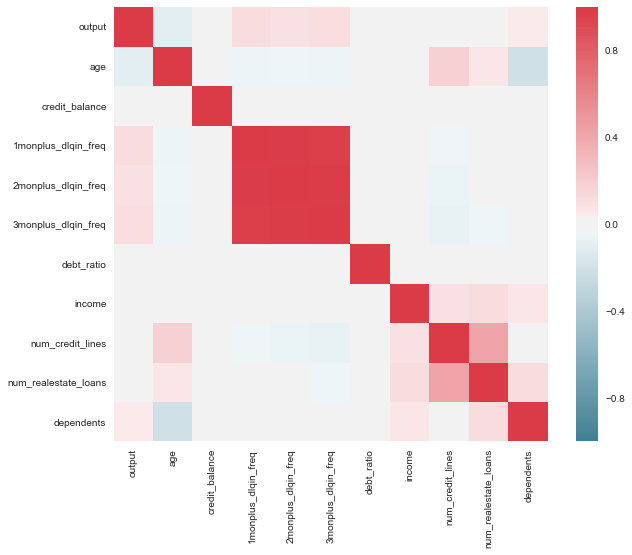

In [26]:
plt.show()

It can be seen from the above correlation plot that output is negatively correlated with age; it is positively correlated with one, two, and three month delinquency frequencies and number of dependents.